## Importing Libraries

Tested on a virtual environment running Python version 3.12.8

In [1]:
!pip install pandas -q
!pip install wheel -q
!pip install ipywidgets -q
!pip install setuptools -q
!pip install xgboost -q
!pip install catboost -q
!pip install -U scikit-learn -q
!pip install matplotlib -q
!pip install seaborn -q
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [4]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from datetime import datetime
import matplotlib.pyplot as plt
from math import log
import numpy as np
import seaborn as sns

## Time to Load the dataset

In [7]:
rent_df = pd.read_csv('/Users/utkarsh/Desktop/Utkarsh/NYU/Year 2/Semester 1/DS/Project/rent-raja/final_data_cleaning/final_cleaned_data.csv')
rent_df.head()

,Unnamed: 0,listedAt,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,...,Hispanic or Latino_ratio,Population Below Poverty Level_ratio,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio
0,0,2024-11-25,1.0,2024-11-25,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
1,1,2024-11-22,4.0,2024-11-22,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
2,2,2024-11-22,4.0,2024-11-22,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
3,3,2024-11-20,6.0,2024-11-20,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939
4,4,2024-11-19,7.0,2024-11-19,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,...,0.194808,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939


## Convert rent variable into a cateogrical variable

In [8]:

num_buckets = 3

# Create quantile-based buckets with integer labels
rent_df['rent_bucket'] = pd.qcut(rent_df['price'], q=num_buckets, labels=[i for i in range(num_buckets)])

# Display the bins and distribution
bin_edges = pd.qcut(rent_df['price'], q=num_buckets, retbins=True)[1]
distribution = rent_df['rent_bucket'].value_counts(normalize=True, sort=False)

label_to_range: dict[int, str] = {i: f"${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f}" for i in range(len(bin_edges) - 1)}

for i in range(len(bin_edges) - 1):
    print(f"Bucket {i+1}: ${bin_edges[i]:,.2f} - ${bin_edges[i+1]:,.2f} with {round(distribution.iloc[i]*100, ndigits=2)}% of data")

Bucket 1: $1,199.00 - $2,300.00 with 14.91% of data
Bucket 2: $2,300.00 - $2,700.00 with 14.12% of data
Bucket 3: $2,700.00 - $3,000.00 with 13.93% of data
Bucket 4: $3,000.00 - $3,500.00 with 16.53% of data
Bucket 5: $3,500.00 - $4,000.00 with 12.76% of data
Bucket 6: $4,000.00 - $5,700.00 with 13.62% of data
Bucket 7: $5,700.00 - $125,000.00 with 14.14% of data


In [6]:
rent_df.head()

,Unnamed: 0,listedAt,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,...,Population Below Poverty Level_ratio,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio,rent_bucket
0,0,2024-11-25,1.0,2024-11-25,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0
1,1,2024-11-22,4.0,2024-11-22,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0
2,2,2024-11-22,4.0,2024-11-22,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0
3,3,2024-11-20,6.0,2024-11-20,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0
4,4,2024-11-19,7.0,2024-11-19,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,...,0.324774,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,2


## Looking at the Dataframe

At some points, there was no census data available, so we drop those rows here.

In [7]:
nan_summary = rent_df.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage'] = (nan_summary['NaN Count'] / len(rent_df)) * 100
nan_summary

,NaN Count,Percentage
Unnamed: 0,0,0.000000
listedAt,5052,64.422341
daysOnMarket,1239,15.799541
availableFrom,1463,18.655955
street,0,0.000000
price,0,0.000000
borough,0,0.000000
neighborhood,5052,64.422341
zip,0,0.000000
propertyType,0,0.000000


In [8]:
rent_df_cleaned = rent_df.dropna(subset=['Employed_ratio'])

### NEighbourhood is empty

time to fill it up

In [9]:
default_datetime = datetime(2024, 11, 28, 0, 0, 0)
def calculate_date_delta(row):
    available_date = pd.to_datetime(row['availableFrom'])
    return (available_date - default_datetime).days

### Other stuff

We delete listedAt because daysOnMarket kind of captures that nuance.

In [10]:
mean_days_on_market = rent_df['daysOnMarket'].mean()
rent_df_cleaned['daysOnMarket'] = rent_df_cleaned['daysOnMarket'].fillna(mean_days_on_market)

rent_df_cleaned['neighborhood'] = rent_df_cleaned['neighborhood'].fillna(rent_df_cleaned['borough'])

rent_df_cleaned['isStreetEasy'] = rent_df_cleaned['amenities'].notnull()

rent_df_cleaned['availableFrom'] = rent_df_cleaned['availableFrom'].fillna(default_datetime)
rent_df_cleaned['availableFrom'] = rent_df_cleaned.apply(calculate_date_delta, axis=1)

rent_df_cleaned.drop(columns=['listedAt', 'amenities', 'builtIn', 'description'], inplace=True)

print(f"Original dataset shape: {rent_df.shape}")
print(f"Cleaned dataset shape: {rent_df_cleaned.shape}")

nan_summary = rent_df_cleaned.isnull().sum().to_frame(name='NaN Count')
nan_summary['Percentage'] = (nan_summary['NaN Count'] / len(rent_df)) * 100
nan_summary

rent_df_cleaned

/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_87330/4033777650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['daysOnMarket'] = rent_df_cleaned['daysOnMarket'].fillna(mean_days_on_market)
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_87330/4033777650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['neighborhood'] = rent_df_cleaned['neighborhood'].fillna(rent_df_cleaned['borough'])
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_87

Original dataset shape: (7842, 50)
Cleaned dataset shape: (6971, 47)


/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_87330/4033777650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned['availableFrom'] = rent_df_cleaned.apply(calculate_date_delta, axis=1)
/var/folders/9p/z5f536ns1rs7nv_0zv0bc91r0000gn/T/ipykernel_87330/4033777650.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rent_df_cleaned.drop(columns=['listedAt', 'amenities', 'builtIn', 'description'], inplace=True)


,daysOnMarket,availableFrom,street,price,borough,neighborhood,zip,propertyType,beds,baths,...,Employed_ratio,Unemployed_ratio,High School Graduate (Age 25+)_ratio,Bachelor’s Degree (Age 25+)_ratio,Graduate or Professional Degree (Age 25+)_ratio,Never Married_ratio,Currently Married_ratio,Divorced_ratio,rent_bucket,isStreetEasy
0,1.000000,-3,171 East 96th Street #4A,1855.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0,True
1,4.000000,-6,93 East 96th Street #11,2235.0,Brooklyn,brownsville,11212,rental,2,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0,True
2,4.000000,-6,501 Saratoga Avenue #B,1750.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0,True
3,6.000000,-8,1115 Willmohr Street #2P,1850.0,Brooklyn,brownsville,11212,rental,1,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,0,True
4,7.000000,-9,1075 Clarkson Avenue #2B,3000.0,Brooklyn,brownsville,11212,rental,3,1.0,...,0.369616,0.061293,0.200164,0.079363,0.002393,0.188141,0.100302,0.026939,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,121.000000,0,1027 Faile St APT 3,4070.0,Bronx,Bronx,10459,apartment,4,1.0,...,0.398834,0.064545,0.133881,0.064083,0.000866,0.207451,0.126357,0.028654,2,False
7831,6.000000,-10,80 Tyrrell St #1,3800.0,Staten Island,Staten Island,10307,apartment,3,3.0,...,0.468655,0.004066,0.140969,0.136089,0.003321,0.148153,0.242765,0.031040,1,False
7839,5.000000,-10,11 Maiden Ln APT 6B,3750.0,Manhattan,Manhattan,10038,apartment,2,1.0,...,0.538791,0.028702,0.060532,0.279527,0.011095,0.239472,0.145440,0.017179,1,False
7840,22.006664,0,88 Fulton St #TOWNHOUSE 1,3200.0,Manhattan,Manhattan,10038,apartment,1,1.0,...,0.538791,0.028702,0.060532,0.279527,0.011095,0.239472,0.145440,0.017179,1,False


## Time to split our dataset

In [11]:
X = rent_df_cleaned.drop(columns=['price', 'rent_bucket'])
y = rent_df_cleaned['rent_bucket']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Training

### CatBoost

We start experimenting with training using Catboost because it doesn't need any categorical data to be encoded in any way or form. 

In [12]:
cat_features = [
    'street',
    'borough',
    'propertyType',
    'neighborhood'
]

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0, 1, 2],
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'boosting_type': ['Ordered', 'Plain']
}

param_grid2 = {
    'iterations': [750, 800, 1000],            # Narrow around the best value
    'depth': [7, 8, 9],                      # Explore slight variations around the best depth
    'l2_leaf_reg': [4, 5, 6],                # Fine-tune regularization
    'bagging_temperature': [0.8, 1, 1.2],    # Focus around the best bagging value
    'border_count': [60, 64, 68],            # Refine around the best border count
    'grow_policy': ['Depthwise'],            # Stick to the best grow policy
    'boosting_type': ['Plain'],              # Stick to the best boosting type
}

param_grid3 = {
    'iterations': [900, 1000, 1100],       # Test slightly higher iterations
    'l2_leaf_reg': [5.5, 6, 6.5],          # Narrow range around the best value
    'bagging_temperature': [0.7, 0.8, 0.9] # Fine-tune around the best value
}


In [13]:
# Initialize and train CatBoost
model = CatBoostClassifier(cat_features=cat_features, task_type='MPS')
# grid_search_result = model.grid_search(param_grid, X=X_train, y=y_train, plot=True)

# Make predictions
# y_pred = model.predict(X_test)

In [14]:
fin_model = CatBoostClassifier(cat_features=cat_features, iterations=900, depth=8, l2_leaf_reg=5.5, bagging_temperature=0.7, border_count=64, grow_policy='Depthwise', boosting_type='Plain')
fin_model.fit(X_train, y_train)

y_pred = fin_model.predict(X_test)

0:	learn: 1.0783223	total: 81.7ms	remaining: 1m 13s
1:	learn: 1.0580331	total: 98.7ms	remaining: 44.3s
2:	learn: 1.0393727	total: 118ms	remaining: 35.3s
3:	learn: 1.0218781	total: 136ms	remaining: 30.6s
4:	learn: 1.0052324	total: 156ms	remaining: 27.9s
5:	learn: 0.9893365	total: 175ms	remaining: 26.1s
6:	learn: 0.9737065	total: 190ms	remaining: 24.2s
7:	learn: 0.9593174	total: 209ms	remaining: 23.2s
8:	learn: 0.9454710	total: 229ms	remaining: 22.6s
9:	learn: 0.9337157	total: 248ms	remaining: 22.1s
10:	learn: 0.9208755	total: 266ms	remaining: 21.5s
11:	learn: 0.9087817	total: 286ms	remaining: 21.1s
12:	learn: 0.8973664	total: 304ms	remaining: 20.7s
13:	learn: 0.8859053	total: 320ms	remaining: 20.3s
14:	learn: 0.8761461	total: 338ms	remaining: 19.9s
15:	learn: 0.8663515	total: 357ms	remaining: 19.7s
16:	learn: 0.8575248	total: 376ms	remaining: 19.5s
17:	learn: 0.8480954	total: 395ms	remaining: 19.3s
18:	learn: 0.8391018	total: 413ms	remaining: 19.1s
19:	learn: 0.8303872	total: 432ms	rema

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.75


## ROC-AUC Time

In [16]:
# Get predicted probabilities for all classes
y_pred_proba = fin_model.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
# Converts y_test to a binary matrix of shape (n_samples, n_classes)
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

print(y_test_binarized)

# Compute the multi-class ROC AUC score
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovo")  # "ovo" is another option
print(f"Multi-Class ROC AUC Score: {roc_auc:.4f}")

[[1 0 0]
 [0 1 0]
 [0 1 0]
 ...
 [1 0 0]
 [1 0 0]
 [0 0 1]]
Multi-Class ROC AUC Score: 0.9008


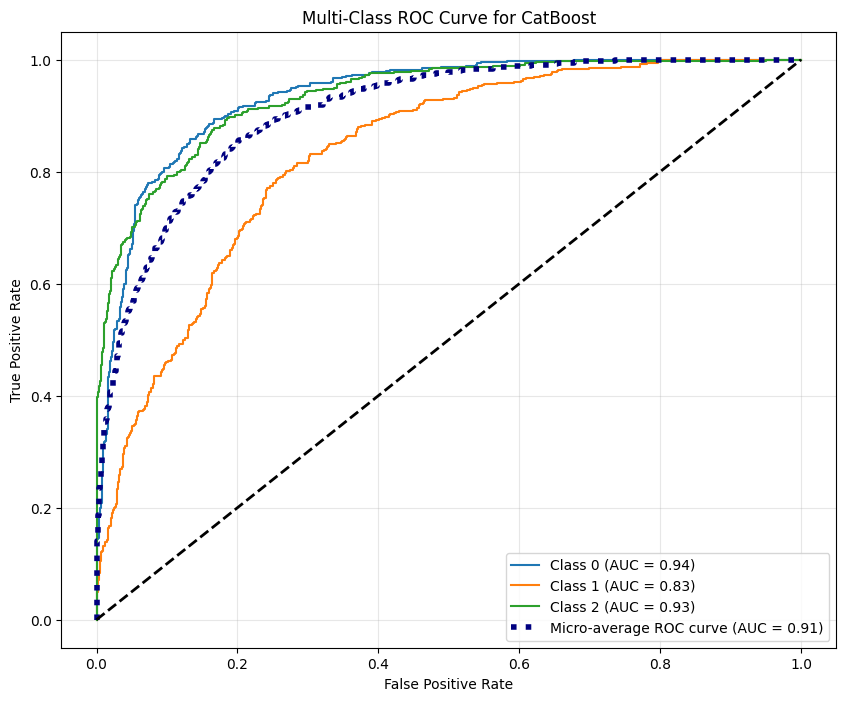

In [17]:
# Get predicted probabilities for all classes
y_pred_proba = fin_model.predict_proba(X_test)

# Binarize the output labels for multi-class AUC
y_test_binarized = label_binarize(y_test, classes=[x for x in range(num_buckets)])  # Adjust classes as per your dataset

# Initialize variables for the ROC curves
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC curve and AUC for each class
for i in range(num_buckets):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_buckets):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         color='navy', linestyle=':', linewidth=4)

# Plot diagonal line for random chance
plt.plot([0, 1], [0, 1], "k--", linewidth=2)

# Add plot details
plt.title("Multi-Class ROC Curve for CatBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

## Confusion Matrix Time

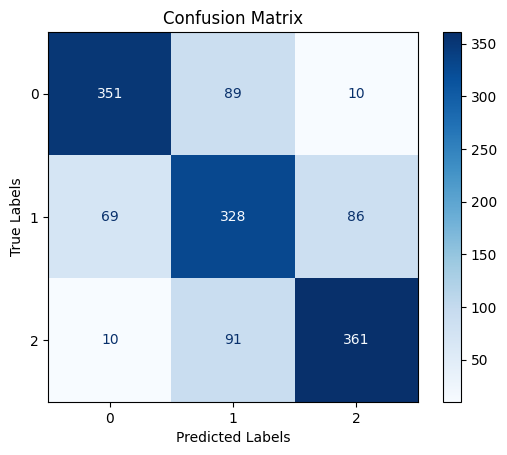

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)

# Beautify the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Interesting Observation

We notice That our model gets the class right or predicts the class right next to it so we think it would be interesting to come up with a relaxed accuracy metric, which will think that the predicted class is correct if it is Numeric adjacent to the correct class

In [19]:
def relaxed_accuracy(y_true, y_pred):
    """
    Calculates accuracy with ±1 tolerance for class predictions.
    
    Parameters:
    y_true (array-like): True class labels.
    y_pred (array-like): Predicted class labels.
    
    Returns:
    float: Relaxed accuracy score.
    """
    # Count correct predictions with ±1 tolerance
    correct = sum(abs(true - pred) <= 1 for true, pred in zip(y_true, y_pred))
    
    # Calculate accuracy
    accuracy = correct / len(y_true)
    
    return accuracy

accuracy = relaxed_accuracy(y_test, y_pred)
print(f"Relaxed Accuracy (±1): {accuracy[0]:.2f}")


Relaxed Accuracy (±1): 0.99


## Weighted Relaxed Accuracy

It's not fair to weight being one class off the true class. So here we propose (casually) a generic function that gives a weighted relaxed accuracy. It wieghts accoridngly 
1. 	Distance Sensitivity:
Classes that are further apart in index (e.g., true class = 5, predicted class = 7) incur a greater penalty than classes that are closer (e.g., predicted = 4 or 6).
2. Range Sensitivity:
Predictions that are off by a class whose range is large are penalized more than predictions off by a class with a smaller range. For instance, guessing a bucket spanning 1000 units is considered a larger error than guessing one spanning 200 units.

In [20]:
bucket_ranges: dict[int, float] = {i: bin_edges[i+1] - bin_edges[i] for i in range(num_buckets)}

max_range = sum(bucket_ranges.values())
normalized_bucket_ranges = {k: (log(v + 1, 1.4) / log(max_range + 1, 20))/10 for k, v in bucket_ranges.items()}

print(normalized_bucket_ranges)

{0: 0.560254831822453, 1: 0.524550614396991, 2: 0.8887235090893697}


In [21]:
def get_penalty(t, p, bucket_ranges, bucket_range_relaxation:float, max_range:float):
    distance = abs(t - p)
    # Average the true and predicted bucket ranges
    avg_range = avg_range = (bucket_ranges[t] + bucket_ranges[p]) / (bucket_range_relaxation + bucket_ranges[t] + bucket_ranges[p])
    # Compute penalty proportional to distance and relative range
    # The larger the distance and avg_range, the greater the penalty.
    penalty = (distance * (avg_range / max_range))
    return penalty

def relaxed_accuracy_with_weighted_ranges(true_labels, pred_labels, bucket_ranges, min_partial_credit:float=0.08, bucket_range_relaxation:float=1.2, grace_threshold:float = 0.08, verbose:bool=False):
    """
    Calculate a "relaxed accuracy" that gives:
    - Full credit (1.0) if prediction == true class.
    - Partial credit if prediction is incorrect, with the score decreasing
      as the class distance and bucket ranges increase.
    - A minimum partial credit is guaranteed for any incorrect prediction 
      so that, on average, relaxed accuracy >= strict accuracy.
    Parameters
    ----------
    true_labels : array-like of shape (n_samples,)
        True class labels.
    pred_labels : array-like of shape (n_samples,)
        Predicted class labels.
    bucket_ranges : dict[int, float]
        A dictionary mapping each class label to its weighted bucket range.
        A higher float value means a larger bucket range.
        
    Returns
    -------
    float
        The mean relaxed accuracy across all predictions.
    """

    assert 0 <= min_partial_credit <= 1, 'min_partial_credit has to between 0 and 1'
    
    max_range = max(bucket_ranges.values()) 
    min_partial_credit = 0.08

    grace_count = 0
    tot = 0
    
    scores = []
    for t, p in zip(true_labels, pred_labels):
        tot += 1
        p = p[0]

        penalty = get_penalty(t, p, bucket_ranges, bucket_range_relaxation, max_range)

        score = max(1 - penalty, 0)
        if score < grace_threshold:
            score += min_partial_credit
            grace_count += 1
        
        scores.append(score)
    if verbose:
        print(f"Grace was given to {grace_count*100/tot}% of predictions.")
        
    return np.mean(scores)

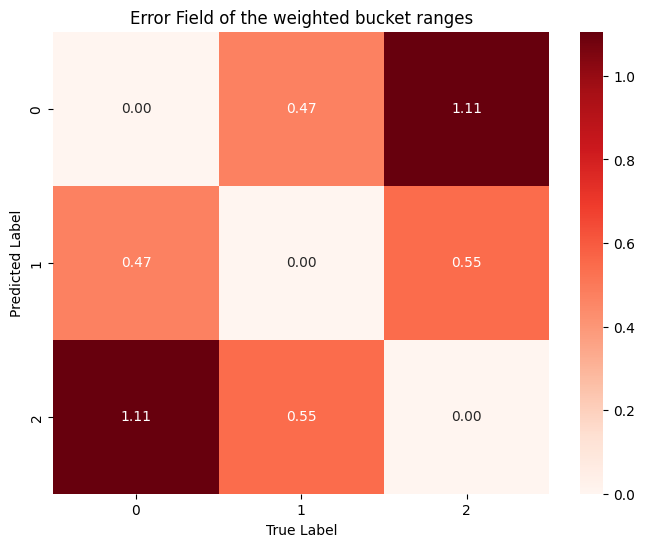

In [22]:
def calculate_err_field(bucket_ranges:dict[int, float]):
    err_field = np.zeros((num_buckets, num_buckets))
    max_range = max(bucket_ranges.values()) 
    for i in range(num_buckets):
        for j in range(num_buckets):
            err_field[i][j] = get_penalty(i, j, bucket_ranges, 1.5, max_range)
    return err_field

err_field = calculate_err_field(normalized_bucket_ranges)

plt.figure(figsize=(8, 6))
sns.heatmap(err_field, annot=True, fmt=".2f", cmap="Reds", cbar=True)

plt.title("Error Field of the weighted bucket ranges")
plt.xlabel("True Label")
plt.ylabel("Predicted Label")
plt.show()


In [23]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges))

0.8490911445132127


## Custom Loss function

Let's see what happens if we use our error field as a loss function to train the model

In [24]:
class CustomLoss:
    def __init__(self, error_matrix):

        self.error_matrix = error_matrix  # Error field as a NumPy array

        print(self.error_matrix)
        

    def calc_ders_multi(self, approxes, target, weights):
        """
        Calculate the gradient (first derivative) and Hessian (second derivative) 
        for a single sample.

        Parameters:
        - approxes: 1D array of predicted logits for one sample.
        - targets: 1D array containing the true label for this sample.
        - weights: Optional sample weights (not used here).

        Returns:
        - Tuple (gradient, hessian).
        """
        # Convert logits to probabilities using softmax

        print("Start calc_ders_multi")
        print(f"approxes: {approxes}, type: {type(approxes)}, shape: {np.shape(approxes)}")
        print(f"target: {target}, type: {type(target)}")
        print(f"weights: {weights}")

        try:
            probabilities = np.exp(approxes - np.max(approxes))
            probabilities /= np.sum(probabilities)
            print(f"Probabilities: {probabilities}")
        except Exception as e:
            print(f"Error during probabilities calculation: {e}")
            raise

        assert len(approxes) == self.error_matrix.shape[0], "approxes must equal error_matrix in length"
        print("done 1")

        probabilities = np.exp(approxes - np.max(approxes))
        probabilities /= np.sum(probabilities)

        assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

        assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

        print("done 2")

        # target = targets  # True class label
        grad = np.zeros_like(probabilities)
        hess = np.zeros_like(probabilities)

        assert target < self.error_matrix.shape[0], "target must be within error_matrix shape"
        assert grad.shape[0] == self.error_matrix.shape[0], 'hmm'

        print('done 3')

        for pred_class in range(len(probabilities)):
            assert int(target) < self.error_matrix.shape[0], "target must be within error_matrix shape"
            assert pred_class < self.error_matrix.shape[0], "pred_class must be within error_matrix shape"

            print("done 4")
            error = self.error_matrix[int(target), pred_class]

            if pred_class == target:
                grad[pred_class] = probabilities[pred_class] - 1  # Gradient for true class
                hess[pred_class] = probabilities[pred_class] * (1 - probabilities[pred_class])  # Hessian
            else:
                grad[pred_class] = probabilities[pred_class]  # Gradient for other classes
                hess[pred_class] = probabilities[pred_class] * (1 - probabilities[pred_class])  # Hessian

            # Scale gradients and Hessians by the error matrix value
            grad[pred_class] *= error
            hess[pred_class] *= error
        
        assert grad.shape == hess.shape, "grad must equal hess in shape"
        print("done 5")

        return grad, hess # Return score for the sample and weight of 1

## Supplying my own accuracy metric to the model

In [25]:
import numpy as np

class RelaxedAccuracyMetric:
    def __init__(self, error_matrix, grace_threshold=0.05, min_partial_credit=0.08, verbose=False):
        """
        Initialize the RelaxedAccuracyMetric class.
        
        Parameters:
        - bucket_ranges: Dictionary mapping class labels to range weights.
        - min_partial_credit: Minimum credit given for incorrect predictions.
        - bucket_range_relaxation: Relaxation factor for range averaging.
        - grace_threshold: Score below which minimum partial credit is applied.
        - verbose: Whether to print additional information.
        """
        self.error_matrix = error_matrix
        self.verbose = verbose
        self.grace_threshold = grace_threshold
        self.min_partial_credit = min_partial_credit

    def get_final_error(self, error, weight):
        """
        Calculate the final error based on weighted error sum.
        
        Parameters:
        - error: The list of error values.
        - weight: The list of weights.
        
        Returns:
        - Weighted average error.
        """
        return np.sum(error) / np.sum(weight)

    def is_max_optimal(self):
        """
        Indicates whether a higher metric value is better.
        
        Returns:
        - True (higher metric values are better).
        """
        return True

    def evaluate(self, approxes, targets, weights=None):
        """
        Evaluate the relaxed accuracy for CatBoost.

        Parameters:
        - approxes: Predicted logits or probabilities (1D array for one sample).
        - targets: True class label (scalar or 1D array).
        - weights: Optional sample weights (not applicable for individual evaluation).

        Returns:
        - Tuple (average relaxed accuracy, total weight sum for the batch).
        """
        assert len(approxes) == 8, "approxes must equal error_matrix in length"
        assert len(approxes.shape) == 1, "Not Okay"
        
        if len(approxes.shape) == 1:  # Single sample
            probabilities = np.exp(approxes - np.max(approxes))
            probabilities /= np.sum(probabilities)

            assert len(probabilities) == self.error_matrix.shape[0], "probabilities must equal error_matrix in length"

            pred_class = np.argmax(probabilities)
            target = targets  # Extract scalar target for this sample

            penalty = self.error_matrix[int(target), pred_class]
            score = max(1 - penalty, 0)
            if score < self.grace_threshold:
                score += self.min_partial_credit

            return score, 1  # Return score for the sample and weight of 1
        else:
            raise ValueError("RelaxedAccuracyMetric received unexpected batch input.")

In [ ]:
custom_loss_model = CatBoostClassifier(cat_features=cat_features, iterations=900, depth=8, l2_leaf_reg=5.5, bagging_temperature=0.7, border_count=64, grow_policy='Depthwise', boosting_type='Plain', loss_function=CustomLoss(err_field), eval_metric=RelaxedAccuracyMetric(err_field), classes_count=num_buckets)
custom_loss_model.fit(X_train, y_train)

y_pred = custom_loss_model.predict(X_test)

In [ ]:
print(relaxed_accuracy_with_weighted_ranges(y_test, y_pred, normalized_bucket_ranges))